In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

import os
import pickle

from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

Проверяем датасет (Всё нормализовано кроме столбцов с классами)

In [148]:
fraction = 0.05

In [149]:
# .sample(frac=0.1) - Для тестирования и быстроты работы возьмём только 10% от выборки
df = pd.read_csv('../Data/global_preprocessed_without_onehot.csv', encoding='ISO-8859-1').sample(frac=fraction, random_state=0)
df.head()

,iyear,extended,region,nkill,nwound,attacktype1,nperps,suicide,success,gname,targtype1
13572,0.234043,0,2,0.000000,0.000000,3,0.077519,0,1,2,19
39531,0.425532,0,3,0.014286,0.000000,1,0.077519,0,1,2,2
168828,1.000000,1,5,0.000000,0.000000,6,0.186047,0,1,1820,14
75336,0.765957,0,6,0.100000,0.000000,3,0.077519,0,1,2,18
68934,0.680851,0,10,0.285714,0.196078,3,0.077519,1,1,1379,14


Выводим данные для просмотра возможных кластеров (не используем столбцы с классами)

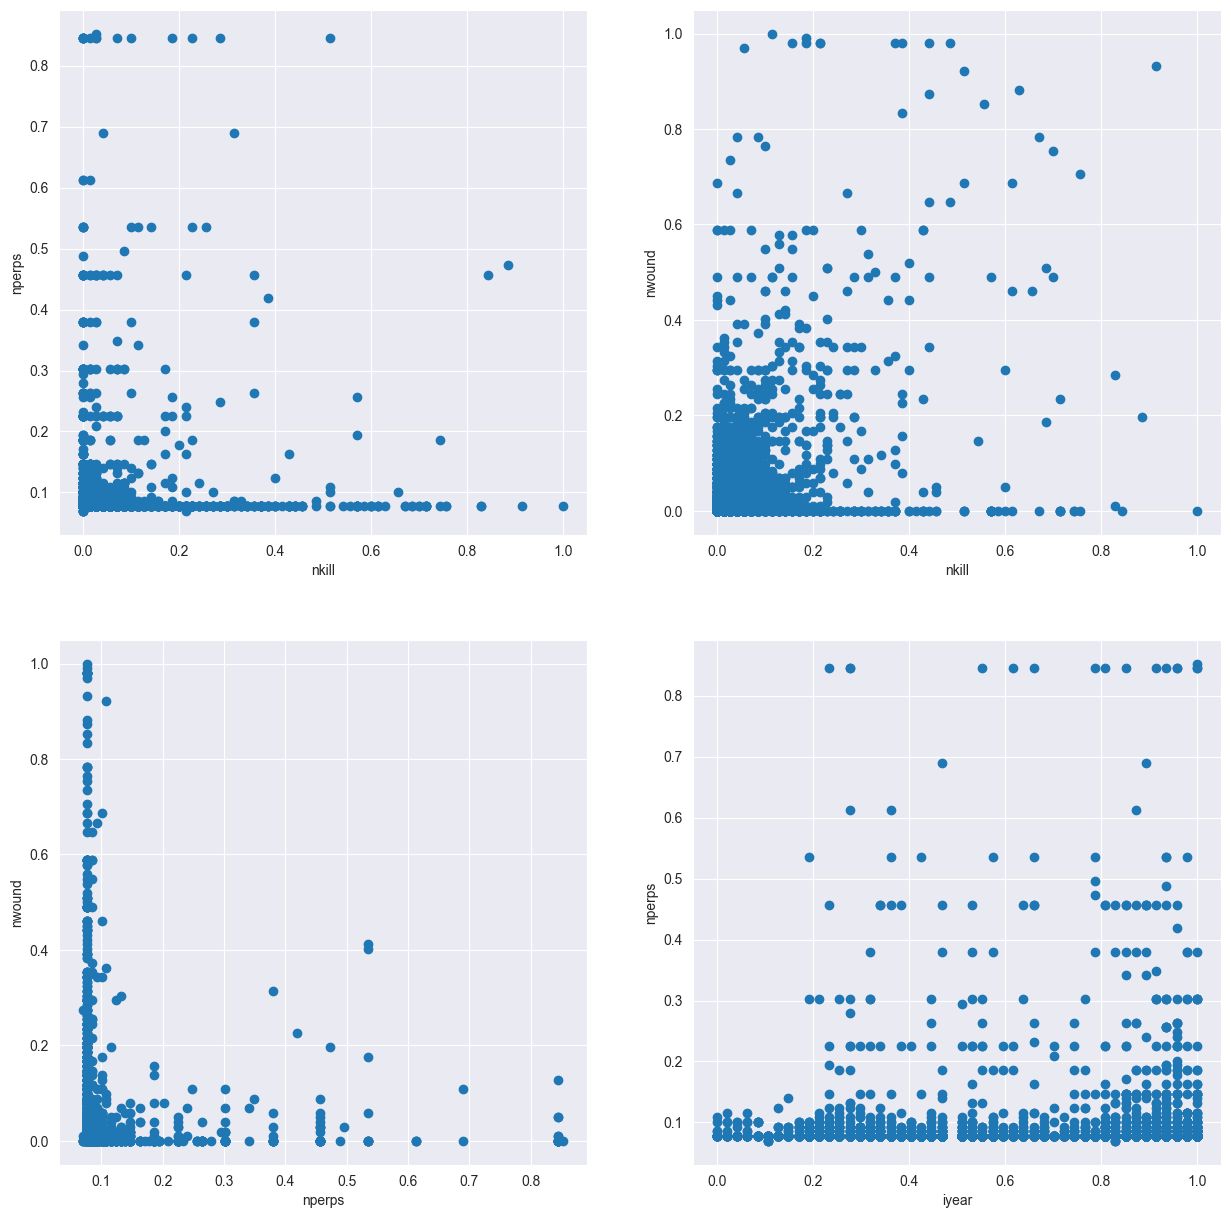

In [150]:
# Массив графиков 2 на 2, размер отображаемой картинки: 15 на 15
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
# Первый график рассеяния: жертвы и террористы
ax[0][0].scatter(df["nkill"], df["nperps"])
ax[0][0].set_xlabel("nkill")
ax[0][0].set_ylabel("nperps")

# Второй график рассеяния: жертвы и раненые
ax[0][1].scatter(df["nkill"], df["nwound"])
ax[0][1].set_xlabel("nkill")
ax[0][1].set_ylabel("nwound")

# Второй график рассеяния: террористы и раненые
ax[1][0].scatter(df["nperps"], df["nwound"])
ax[1][0].set_xlabel("nperps")
ax[1][0].set_ylabel("nwound")

# Второй график рассеяния: года и террористы
ax[1][1].scatter(df["iyear"], df["nperps"], label="f")
ax[1][1].set_xlabel("iyear")
ax[1][1].set_ylabel("nperps")
plt.show()

Разбиваем на кластеры по самым подходящим параметрам (выбираем понравившийся график)

In [151]:
df_two = df[["nkill", "nperps"]]

Используем различные алгоритмы

Используем алгоритм KMeans

In [152]:
kmeans = KMeans(n_clusters=3, max_iter=300, tol=1e-4, n_init="auto", verbose=0, algorithm="elkan")
kmeans.fit(df_two)

KMeans(algorithm='elkan', n_clusters=3, n_init='auto')

Используем алгоритм DBSCAN

In [153]:
dbscan = DBSCAN(eps=0.1, min_samples=3, n_jobs=-1)
dbscan.fit(df_two)

DBSCAN(eps=0.1, min_samples=3, n_jobs=-1)

Используем иерархический алгоритм

In [154]:
h_clustering = AgglomerativeClustering(n_clusters=3)
h_clustering.fit(df_two)

AgglomerativeClustering(n_clusters=3)

Смотрим на результаты разбиения на кластеры

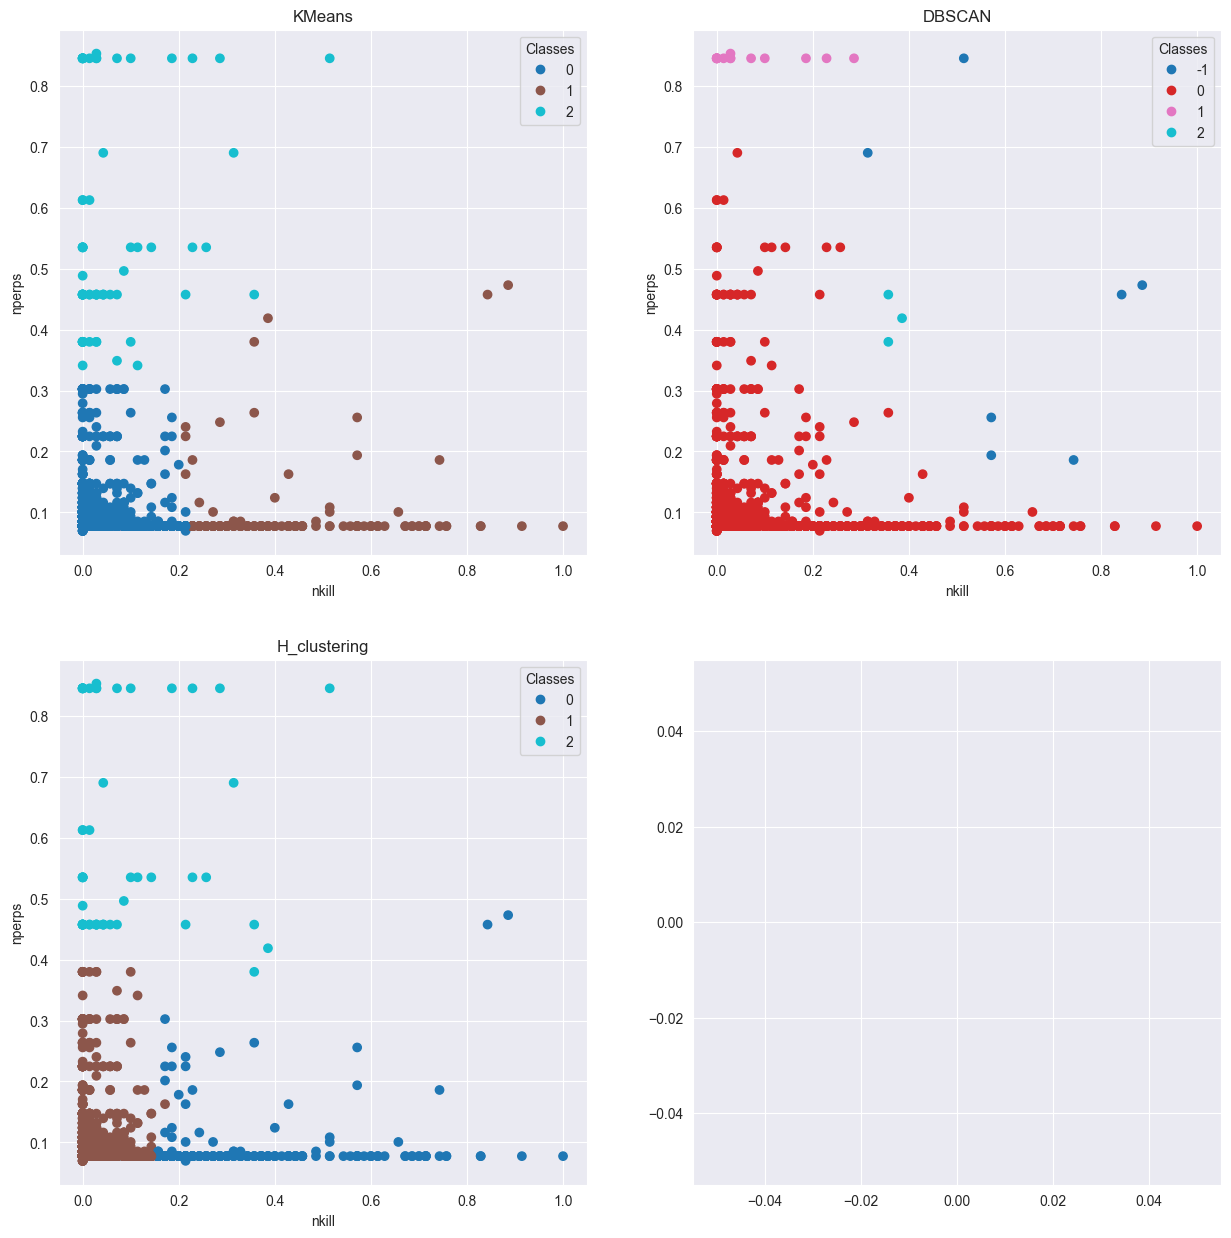

In [155]:
def prepare_and_plot(ax, model, title):
    labels = np.unique(model.labels_)  # получаем список уникальных меток
    colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))    # создаем массив цветов
    ax.scatter(df["nkill"], df["nperps"], c=model.labels_, cmap='tab10')  # указываем нашу карту цветов
    # Создаем легенду в виде списка с данными о маркерах, цветах и метках
    handle_list = [plt.plot([], marker="o", ls="", color=color)[0] for color in colors]
    ax.legend(handle_list, labels, title='Classes')
    ax.set_xlabel("nkill")
    ax.set_ylabel("nperps")
    ax.set_title(title)

fig, ax = plt.subplots(2, 2, figsize=(15, 15))

prepare_and_plot(ax[0][0], kmeans, "KMeans")
prepare_and_plot(ax[0][1], dbscan, "DBSCAN")
prepare_and_plot(ax[1][0], h_clustering, "H_clustering")

plt.show()

Используем GridSearch (подбор гиперпараметров для вышеперечисленных алгоритмов)

Выбираем гиперпараметры, которые будем перебирать

In [156]:
agglomerative_params = {
    "n_clusters": [2, 3, 4],
    "linkage": ["ward", "complete", "average"]
}

kmeans_params = {
    "n_clusters": [2, 3, 4],
    "n_init": [1]
}

dbscan_params = {
    "eps": [0.005, 0.05, 0.1],
    "min_samples": [2, 3, 6, 8]
}

In [157]:
# Создаем список из экземпляров алгоритмов и соответствующих гиперпараметров
algorithms = [
    (AgglomerativeClustering(), agglomerative_params),
    (KMeans(), kmeans_params),
    (DBSCAN(), dbscan_params)
]

best_models = {}  # Сохраняем лучшие модели

Обучаем модели

In [158]:

# Цикл по алгоритмам и их гиперпараметрам
for algorithm, params in algorithms:
    model_file = f'best_{algorithm.__class__.__name__}_model.pkl'
    
    if os.path.exists(model_file):
        # Если файл с моделью уже существует, загружаем модель из файла
        with open(model_file, 'rb') as f:
            best_model = pickle.load(f)
        print(f"Loaded model for {algorithm.__class__.__name__} from {model_file}")
    else:
        best_score = 0
        best_params = None
        best_model = None
    
        # Генерируем все комбинации гиперпараметров
        param_grid = list(ParameterGrid(params))
    
        # Цикл по комбинациям гиперпараметров
        for param in param_grid:
            # Устанавливаем гиперпараметры для текущей комбинации
            algorithm.set_params(**param)
    
            # Оцениваем модель
            # Используется метрика silhouette_score для оценки качества кластеризации
            algorithm.fit(df_two)
            labels = algorithm.labels_
            try:
                score = silhouette_score(df_two, labels)
            except ValueError:
                print(f"Error with scoring: {algorithm.__class__.__name__}. {param}")
                score = -1
            # Сохраняем лучшие гиперпараметры
           
            if score > best_score:
                best_score = score
                best_params = param
                best_model = algorithm
        # Выводим лучшие гиперпараметры для текущего алгоритма
        print(f"Best parameters for {algorithm.__class__.__name__}: {best_params}. Score: {best_score}")
    
        # Сохраняем лучшую модель
        with open(f'best_{algorithm.__class__.__name__}_model.pkl', 'wb') as f:
            pickle.dump(best_model, f)
        
    best_models[algorithm.__class__.__name__] = best_model  # Добавляем лучшую модель в список

Loaded model for AgglomerativeClustering from best_AgglomerativeClustering_model.pkl
Loaded model for KMeans from best_KMeans_model.pkl
Loaded model for DBSCAN from best_DBSCAN_model.pkl


In [159]:
h_clustering = best_models["AgglomerativeClustering"]
kmeans = best_models["KMeans"]
dbscan = best_models["DBSCAN"]

Визуализация полученных значений

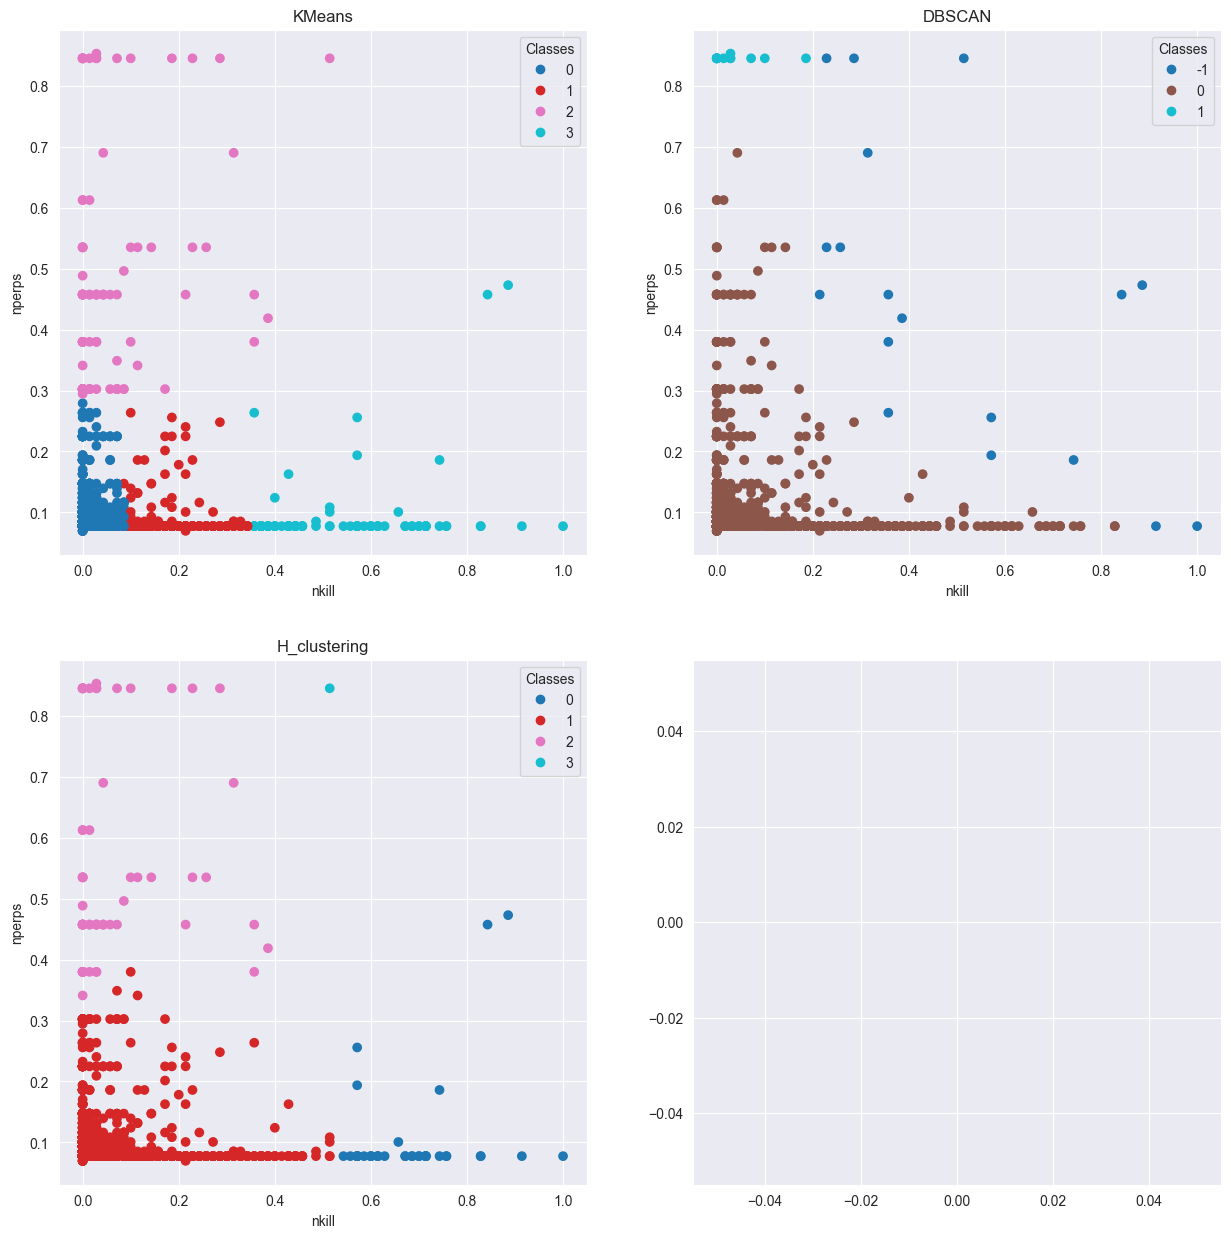

In [160]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

prepare_and_plot(ax[0][0], kmeans, "KMeans")
prepare_and_plot(ax[0][1], dbscan, "DBSCAN")
prepare_and_plot(ax[1][0], h_clustering, "H_clustering")
plt.show()

Сравнение разбиения на кластеры с помощью кластеризации с реальными

Получение всех данных без нормализации для проверки

In [161]:
df_global = pd.read_csv('../Data/global_preprocessed_without_onehot_and_norm.csv', encoding='ISO-8859-1').sample(frac=fraction, random_state=0)

Выводим кластеры KMeans

In [162]:
df_KMeans = df_global.copy()[["nkill", "nperps"]]
df_KMeans["labels"] = kmeans.labels_
df_KMeans.groupby("labels").mean()

,nkill,nperps
labels,,
0,0.801272,1.380025
1,11.337004,1.755507
2,4.138298,53.723404
3,37.175824,3.241758


Выводим кластеры DBSCAN

In [163]:
df_DBSCAN = df_global.copy()[["nkill", "nperps"]]
df_DBSCAN["labels"] = dbscan.labels_
df_DBSCAN.groupby("labels").mean()

,nkill,nperps
labels,,
-1,35.111111,48.277778
0,1.718588,1.750000
1,2.461538,100.076923


Выводим кластеры AgglomerativeClustering

In [164]:
df_Agglomerative = df_global.copy()[["nkill", "nperps"]]
df_Agglomerative["labels"] = h_clustering.labels_
df_Agglomerative.groupby("labels").mean()

,nkill,nperps
labels,,
0,47.550000,4.875000
1,1.548314,1.501728
2,4.369231,62.923077
3,36.000000,100.000000


Выводим классы по типам атаки

In [165]:
df_global.groupby("attacktype1").mean()[["nkill", "nperps"]]

,nkill,nperps
attacktype1,,
1,1.303812,1.630045
2,2.976757,2.840541
3,1.501880,1.298872
4,0.589744,2.282051
5,2.576923,12.115385
6,1.328413,2.944649
7,0.301181,2.730315
8,0.255319,3.553191
9,3.555911,2.821086


Выводим классы типов атаки в виде диаграммы рассеивания для наглядности (необязательный пункт, на этом этапе можно использовать совершенно разные инструменты)

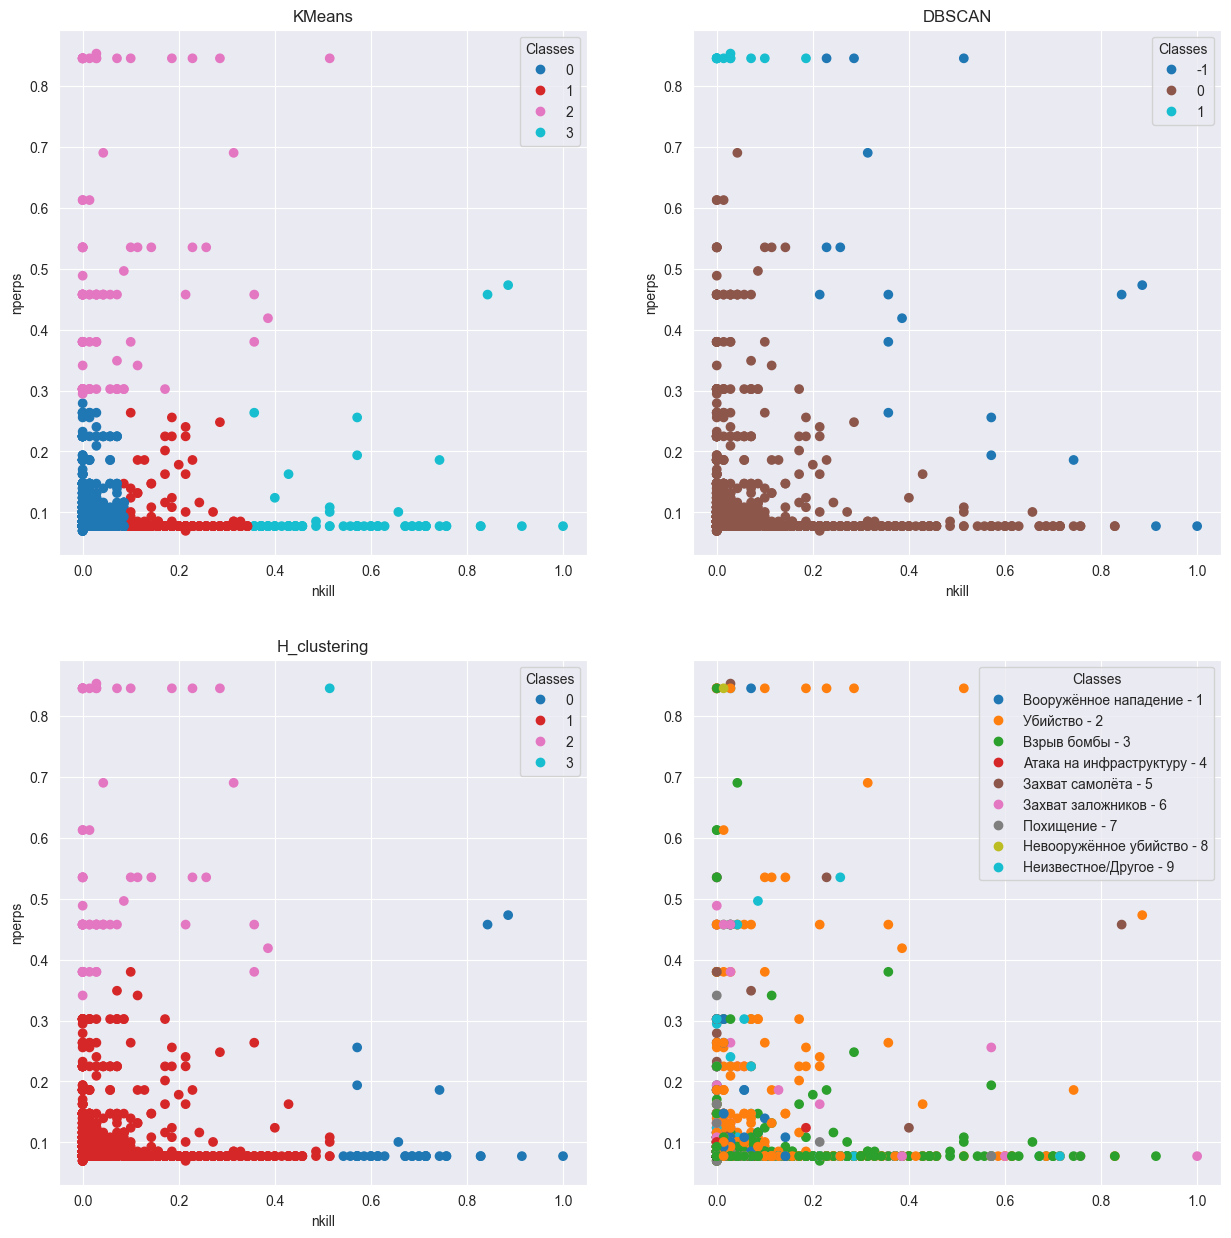

In [166]:
# Стандартные результаты кластеризации
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

prepare_and_plot(ax[0][0], kmeans, "KMeans")
prepare_and_plot(ax[0][1], dbscan, "DBSCAN")
prepare_and_plot(ax[1][0], h_clustering, "H_clustering")

# Добавление диаграммы с известными классами 
labels = ["Вооружённое нападение - 1", "Убийство - 2", "Взрыв бомбы - 3", "Атака на инфраструктуру - 4",
"Захват самолёта - 5", "Захват заложников - 6", "Похищение - 7", "Невооружённое убийство - 8",
"Неизвестное/Другое - 9"]  # получаем список уникальных меток
colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))    # создаем массив цветов
ax[1][1].scatter(df["nkill"], df["nperps"], c=df_global['attacktype1'], cmap='tab10')  # указываем нашу карту цветов
# Создаем легенду в виде списка с данными о маркерах, цветах и метках
handle_list = [ax[1][1].plot([], marker="o", ls="", color=color)[0] for color in colors]
ax[1][1].legend(handle_list, labels, title='Classes')
plt.show()

Вооружённое нападение - 1
Убийство - 2
Взрыв бомбы - 3
Атака на инфраструктуру - 4
Захват самолёта - 5
Захват заложников - 6
Похищение - 7
Невооружённое убийство - 8
Неизвестное/Другое - 9